<a href="https://colab.research.google.com/github/kithmini-wijesiri/Predictive-models-to-assess-inhibitory-activity-EGFR-kinase/blob/main/GNNs_to_assess_inhibitory_activity_against_EGFR_kinase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Project Outline
- Data analysis
- Molecular representation
- Model training and evaluation
  - ECFP + Random forest regressor
  - GNN model
- Virtual screening
- Compound prioritization


In [1]:
# # setting up google colab enviroment
# # install condacolab
!pip install -q condacolab
import condacolab
condacolab.install()

# # copy from github
#!git clone https://github.com/valence-labs/mtl_summer_school_2024.git

# # change working directory
import os
#os.chdir("/content/mtl_summer_school_2024/Lab1")

# # install dependencies
!mamba env update -n base -f env.yml

✨🍰✨ Everything looks OK!
conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
pytorch/linux-64                                            Using cache
pytorch/noarch                                              Using cache
[+] 0.0s
pyg/linux-64  ⣾  
pyg/noarch    ⣾  [+] 0.1s
pyg/linux-64  ⣾  
pyg/noarch    ⣾  [+] 0.2s
pyg/linux-64  ⣾  
pyg/noarch    ⣾  [+] 0.3s
pyg/linux-64  ⣾  
pyg/noarch    ⣾  pyg/linux-64                                                  No change
pyg/noarch                                                    No change


Looking for: ['python', 'pip', 'tqdm', 'loguru', 'numpy', 'pandas', 'scipy', 'scikit-learn', 'seaborn', 'pytorch', 'pyg', 'splito', 'auroris', 'umap-learn', 'rdkit=2023.9.5', "datamol[version='>=0.12.4']", 'molfeat', 'jupyterlab']



  Pinned packages:

  - python 3.10.*
  - python_abi 3.10.* *cp310*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  Al

### Load compound and activity data

- `MOL_smiles`: SMILES string of the corresponding compound.

- `pIC50`: Measured inhibition.

In [9]:
import pandas as pd
import datamol as dm
import numpy as np

# load pre-processed data
data = pd.read_csv("/content/egfr_pIC50_data.csv")
mol_col = "MOL_smiles"
data_col = "pIC50"

In [10]:
# Look at head
print("Shape of dataframe : ", data.shape)
data.head()

Shape of dataframe :  (4396, 4)


,MOL_smiles,pIC50,Gene_Symbol,Original_Entry_ID
0,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...,6.73,EGFR,CHEMBL175513
1,O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21,6.80,EGFR,CHEMBL268868
2,CC(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc5sncc45)c(Cl...,8.54,EGFR,CHEMBL2048906
3,CCOc1ccc(-c2nn(C3CCCC3)c3ncnc(N)c23)cc1OC,5.85,EGFR,CHEMBL1240554
4,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,9.70,EGFR,CHEMBL553


To define an active compound, an activity cut-off ranging from an pIC50 value of 5 to 7 is typically used in drug discovery programs.

Here we use a pIC50 value of 6 which is commonly used to define an active compound.

pIC50 = 6 => IC50 1uM



Text(3, 550, 'IC50=10 uM ')

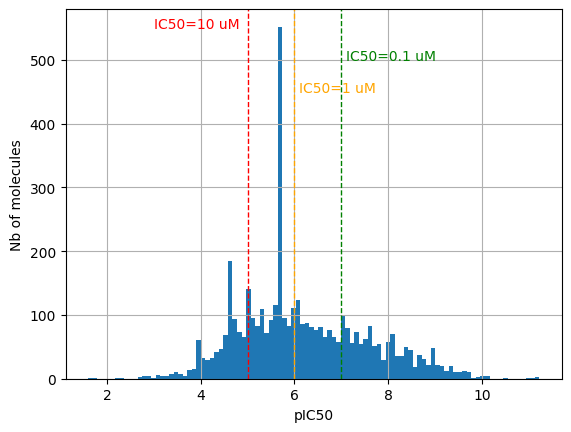

In [11]:
from matplotlib import pyplot as plt

fig = data[data_col].hist(bins=100)
plt.xlabel("pIC50")
plt.ylabel("Nb of molecules")
fig.axvline(6, color="orange", linestyle="dashed", linewidth=1)
fig.annotate("IC50=1 uM", xy=(6, 450), xytext=(6.1, 450), color="orange")
fig.axvline(7, color="green", linestyle="dashed", linewidth=1)
fig.annotate("IC50=0.1 uM ", xy=(7, 500), xytext=(7.1, 500), color="green")
fig.axvline(5, color="red", linestyle="dashed", linewidth=1)
fig.annotate("IC50=10 uM ", xy=(3, 550), xytext=(3, 550), color="red")

## Molecular representation
For ML, molecules need to be converted into features/representation.
Here we focus on **Fingerprint** and **Molecular Graph**.

### Morgan fingerprints ECFP
Extended-Connectivity Fingerprints (ECFPs) are circular topological fingerprints designed for molecular characterization, similarity searching, and structure-activity modeling. We use Morgan fingerprint an implementation from RDKit.

The two most important parameters of these fingerprints are the `radius` and `fingerprint length`. The first specifies the radius of circular neighborhoods considered for each atom. The length parameter specifies the length to which the bit string representation is hashed.

The RDKit implementation is avalaible in [molfeat](https://molfeat.datamol.io/), which is a hub for all molecular featurizers.

In [12]:
from molfeat.trans.fp import FPVecTransformer

fp_transformer = FPVecTransformer(kind="ecfp:4", length=2048)
features = fp_transformer(data[mol_col].values)

# or use `datamol.to_fp`
# features = np.array([dm.to_fp(smi) for smi inn data[mol_col].values])

print(features)
features.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(4396, 2048)

In [13]:
# get the inhibition values
activities = data[data_col].values
activities

array([6.73, 6.8 , 8.54, ..., 6.21, 6.25, 5.8 ])

Use those molecular fingerprints as features as the inputs for ML model.

###  Molecular graph representation

Here we convert the smiles to pyg graph object directly using `PYGGraphTransformer` from `molfeat`.

Each graph in the dataset is encapsulated in a PyG Data object, a convient way of representing all structured data for use in Geometric Deep Learning (including graphs, point clouds, and meshes).

In [14]:
### Process smiles into `torch_geometric.Data` objects
from molfeat.trans.graph.adj import PYGGraphTransformer

# convert smiles to Rdkit.Mol object
mols = dm.parallelized(fn=dm.to_mol, inputs_list=data[mol_col], progress=True)

# convert Rdkit.Mol object to `torch_geometric.Data` object
transformer = PYGGraphTransformer()
pyg_features = transformer(mols)

  0%|          | 0/4396 [00:00<?, ?it/s]

/usr/local/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [15]:
#### Example of a molecular graph object
pyg_mol = pyg_features[0]
pyg_mol

Data(x=[43, 82], edge_index=[2, 94])

In [16]:
# Visualize the adjacent matrix of the above graph object
from torch_geometric.utils import to_dense_adj

to_dense_adj(pyg_mol.edge_index)

tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]]])

=> We can use pyg graph object as input for GNN modeling for inhibition prediction.

## Model training

Goal - to test the ability of the model to predict data which it has never seen before in order to flag problems known as over fitting and to assess the generalization ability of the model.

We start by defining a function model_performance which evaluate a model on a **train-test split** of the data and returns measures such as `mean_squared_error`, `pearsonr` and `spearmanr` evaluated on the heldout test set. We also plot the scatter plot of the true bioactivity and predictions with a linear regression model fit.

#### Utility functions

In [17]:
from loguru import logger
import torch
from scipy import stats
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, precision_recall_fscore_support

In [18]:
# Metrics
def pearsonr(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculate a pearson r correlation"""
    return stats.pearsonr(y_true, y_pred).statistic


def spearman(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculate a Spearman correlation"""
    return stats.spearmanr(y_true, y_pred).statistic


def model_performance(
    ml_model, test_x, test_y, threshold=6, verbose=True, reg_plot: bool = True
):
    """
    Helper function to calculate model performance

    Args
    ----------
    ml_model: model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)
    reg_plot: bool
        Scatter plot between predicion and true values.

    Returns
    -------
    tuple:
        MSE, Pearson R, Spearman, Precision, Recall and Fsocre on test set.
    """

    # Prediction class on test
    if isinstance(ml_model, RandomForestRegressor):
        test_pred = ml_model.predict(test_x)
    else:
        ml_model.eval()  # set model to evaluate mode
        test_pred = torch.cat([ml_model.predict(x) for x in test_x]).numpy().flatten()

    # Performance of model on test set
    ## regression
    mse = mean_squared_error(test_y, test_pred)
    pearsonr_score = pearsonr(test_y, test_pred)
    spearman_score = spearman(test_y, test_pred)
    ## classification
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_true=test_y > threshold, y_pred=test_pred > threshold, average="binary"
    )

    if verbose:
        # Print performance results
        logger.info(f"mean_squared_error: {mse:.2f}")
        logger.info(f"pearson r: {pearsonr_score:.2f}")
        logger.info(f"spearman: {spearman_score:.2f}")
        logger.info(f"precision: {precision:.2f}")
        logger.info(f"recall: {recall:.2f}")
        logger.info(f"fscore: {fscore:.2f}")

    if reg_plot:
        plot_df = pd.DataFrame({"y_true": test_y, "y_pred": test_pred})
        sns.set_style("whitegrid")
        fig = sns.regplot(data=plot_df, x="y_true", y="y_pred")
        fig.axvline(threshold, color="orange", linestyle="dashed", linewidth=1)
        fig.axhline(threshold, color="orange", linestyle="dashed", linewidth=1)

    return mse, pearsonr_score, spearman_score, precision, recall, fscore

#### Data splitting for hit identification

**Scaffold splitting** is approach that identifies chemical series or scaffolds in the dataset and moving all molecules sharing one or more scaffolds to the test set. \
The **goal** is to evaluate how well a model performs on scaffolds and regions of chemical space that differ from those it was trained on.

In [19]:
from splito._scaffold_split import get_scaffold

# compute Murcko scaffolds
scaffolds = dm.utils.parallelized(
    fn=get_scaffold, inputs_list=data[mol_col].tolist(), n_jobs=-1, progress=True
)
print(
    f"There are unique {len(set(scaffolds))} scaffolds for {len(data)} molecules in the dataset."
)

  0%|          | 0/4396 [00:00<?, ?it/s]

There are unique 1777 scaffolds for 4396 molecules in the dataset.


In [20]:
# Create scaffold-base train-test split
from splito import ScaffoldSplit

spliter = ScaffoldSplit(
    smiles=data[mol_col].values, n_splits=5, test_size=0.2, random_state=111
)
train_index, test_index = next(spliter.split(features))

print("Training data size:", len(train_index))
print("Test data size:", len(test_index))

Training data size: 3355
Test data size: 1041


In [6]:
!pip install chemspace_viz

ERROR: Could not find a version that satisfies the requirement chemspace_viz (from versions: none)
ERROR: No matching distribution found for chemspace_viz


/usr/local/lib/python3.10/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


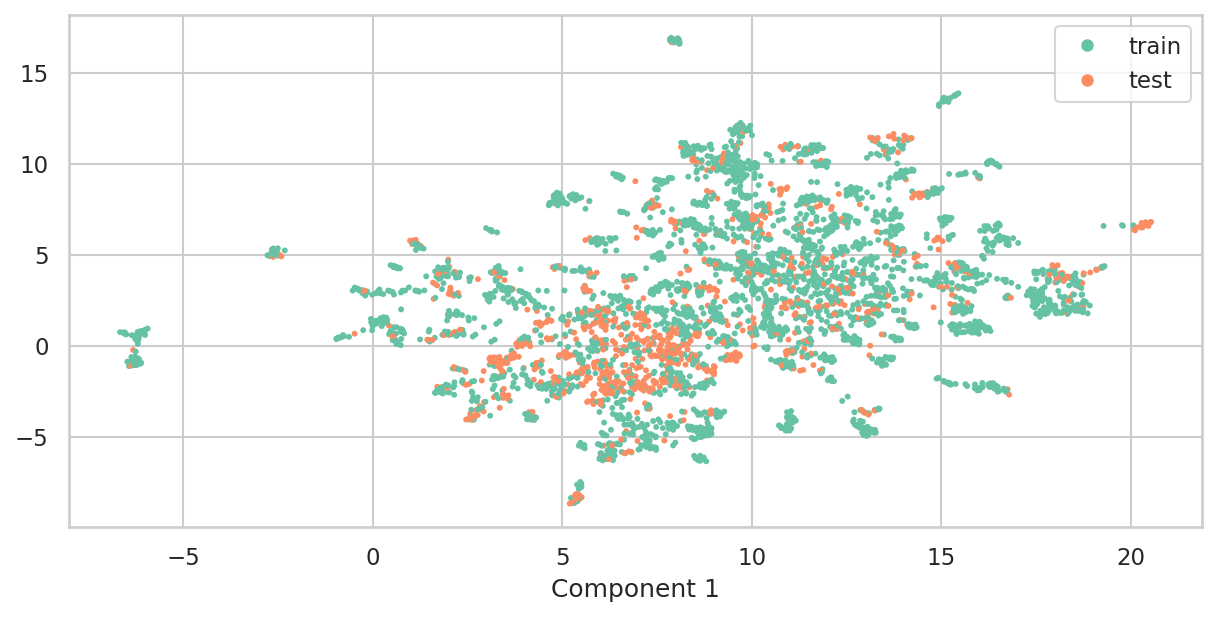

In [21]:
# Visualize their distribution within the chemical space
from chemspace_viz import visualize_chemspace

split_labels = np.full(len(features), "train", dtype=object)
split_labels[test_index] = "test"
fig = visualize_chemspace(
    X=features, y=[split_labels], metric="jaccard", min_dist=0.5, random_state=42
)

#### Random forest regressor for inhibition prediction

In [22]:
# Get the features and bioactivities of the training set
train_x, train_y = features[train_index], activities[train_index]

print("Training set data shape:", train_x.shape)

Training set data shape: (3355, 2048)


In [23]:
# Define a model and train
from sklearn.ensemble import RandomForestRegressor

# Set model parameter for random forest
rf_param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "squared_error",  # cost function to be optimized for a split
}

RF_model = RandomForestRegressor(**rf_param)

In [24]:
# Fit model on single train split
RF_model.fit(train_x, train_y)

RandomForestRegressor()

2024-09-03 19:08:39.429 | INFO     | __main__:model_performance:56 - mean_squared_error: 1.00
2024-09-03 19:08:39.430 | INFO     | __main__:model_performance:57 - pearson r: 0.76
2024-09-03 19:08:39.433 | INFO     | __main__:model_performance:58 - spearman: 0.77
2024-09-03 19:08:39.437 | INFO     | __main__:model_performance:59 - precision: 0.81
2024-09-03 19:08:39.438 | INFO     | __main__:model_performance:60 - recall: 0.89
2024-09-03 19:08:39.441 | INFO     | __main__:model_performance:61 - fscore: 0.85


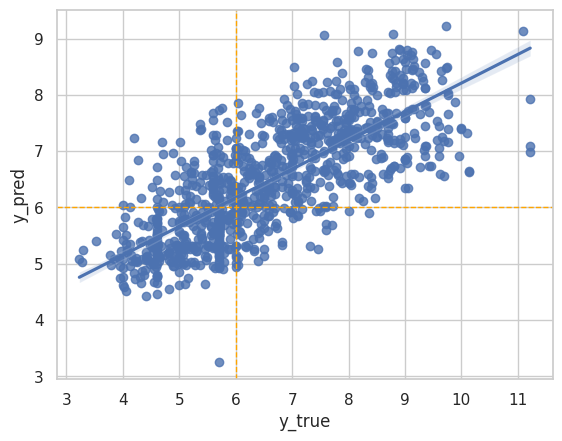

In [25]:
# Get the features and bioactivities of the test set
test_x, test_y = features[test_index], activities[test_index]

# Compute the performance and generate the plot
res = model_performance(RF_model, test_x, test_y, verbose=True, threshold=6)

In [29]:
# Dump the transformer and model to pickle file
import pickle

with open("rf_regressor.pkl", "wb") as fout:
    pickle.dump((fp_transformer, RF_model), fout)

#### Validation on scaffold-based splits



In [30]:
# define cross validation process and metrics

from sklearn import clone


def cross_validation(
    ml_model, spliter, features, activities, verbose=True, threshold=6
):
    """
    Machine learning model training and validation in a cross-validation loop.
    """
    # Results for each of the cross-validation folds
    pearsonr_per_fold = []
    spearman_per_fold = []
    mse_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    fscore_per_fold = []

    # Loop over the folds
    for train_index, test_index in spliter.split(features):

        # clone the newly initiated model
        fold_model = clone(ml_model)

        # Training

        # Convert the fingerprint and the label to a list
        train_x = features[train_index]
        train_y = activities[train_index]

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = features[test_index]
        test_y = activities[test_index]

        # Performance for each fold
        mse, pearsonr_score, spearman_score, precision, recall, fscore = (
            model_performance(
                ml_model=fold_model,
                test_x=test_x,
                test_y=test_y,
                verbose=verbose,
                threshold=threshold,
                reg_plot=False,
            )
        )

        # Save results
        mse_per_fold.append(mse)
        pearsonr_per_fold.append(pearsonr_score)
        spearman_per_fold.append(spearman_score)
        precision_per_fold.append(precision)
        recall_per_fold.append(recall)
        fscore_per_fold.append(fscore)

    # Print statistics of results
    print(
        f"Mean mean squared error: {np.mean(mse_per_fold):.2f} \t"
        f"and std : {np.std(mse_per_fold):.2f} \n"
        f"Mean pearsonr: {np.mean(pearsonr_per_fold):.2f} \t"
        f"and std : {np.std(pearsonr_per_fold):.2f} \n"
        f"Mean spearman: {np.mean(spearman_per_fold):.2f} \t"
        f"and std : {np.std(spearman_per_fold):.2f} \n"
        f"Mean precision: {np.mean(precision_per_fold):.2f} \t"
        f"and std : {np.std(precision_per_fold):.2f} \n"
        f"Mean recall: {np.mean(recall_per_fold):.2f} \t"
        f"and std : {np.std(recall_per_fold):.2f} \n"
        f"Mean fscore: {np.mean(fscore_per_fold):.2f} \t"
        f"and std : {np.std(fscore_per_fold):.2f} \n"
    )

    meric_per_fold = {
        "mse": mse_per_fold,
        "pearsonr": pearsonr_per_fold,
        "spearman": spearman_per_fold,
        "precision": precision_per_fold,
        "recall": recall_per_fold,
        "fscore": fscore_per_fold,
    }
    sns.boxplot(meric_per_fold, palette="pastel").set(
        title="Evaluation cross 10 splits"
    )

Mean mean squared error: 0.80 	and std : 0.13 
Mean pearsonr: 0.76 	and std : 0.03 
Mean spearman: 0.74 	and std : 0.03 
Mean precision: 0.79 	and std : 0.03 
Mean recall: 0.82 	and std : 0.05 
Mean fscore: 0.81 	and std : 0.04 



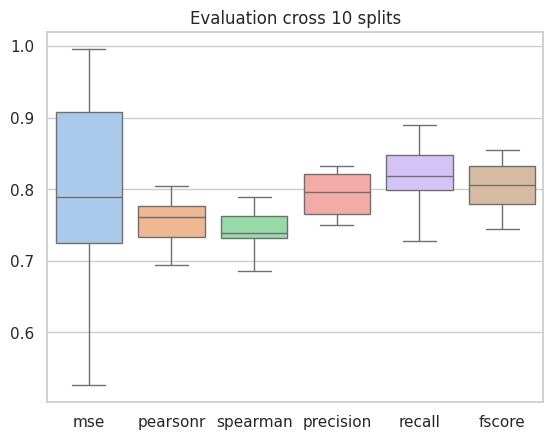

In [31]:
spliter = ScaffoldSplit(
    smiles=data[mol_col].values, n_splits=10, test_size=0.2, random_state=111
)
cross_validation(
    ml_model=RandomForestRegressor(**rf_param),
    spliter=spliter,
    features=features,
    activities=activities,
    threshold=6,
    verbose=False,
)

<!-- <img src="figures/validation.png" width="500"/> -->



#### Graph neural network for inhibition prediction

Here we train a graph neural network model with 3 convolutional layers and a followed by a linear transformer for final output.

In [32]:
import torch
from gnn import GCNModel

# Define the graph model
# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create network and send to the device memory
gnn_model = GCNModel(
    in_channels=transformer(mols[0])[0].x.shape[1],
    hidden_channels=128,
    out_channels=1,
    num_layers=3,
    is_reg=True,
).to(device)

# Use Adam optimizer
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001, weight_decay=0)

# Define the loss function
loss_fn = torch.nn.MSELoss()

In [33]:
# Display the GNN model
gnn_model

GCNModel(
  (conv_layers): ModuleList(
    (0): GCNConv(82, 128)
    (1-3): 3 x GCNConv(128, 128)
  )
  (out): Linear(in_features=256, out_features=1, bias=True)
)

In [34]:
from molfeat.trans.graph.adj import PYGGraphTransformer

# convert smiles to Rdkit.Mol object
mols = np.array(dm.parallelized(fn=dm.to_mol, inputs_list=data[mol_col], progress=True))

# converT Rdkit.Mol object to `torch_geometric.Data` object
transformer = PYGGraphTransformer()

train_set = []
for index in train_index:
    pyg_data = transformer(mols[index])[0]
    pyg_data.y = torch.from_numpy(np.array([activities[index]])).to(torch.float32)
    train_set.append(pyg_data)

test_set = []
for index in test_index:
    pyg_data = transformer(mols[index])[0]
    pyg_data.y = torch.from_numpy(np.array([activities[index]])).to(torch.float32)
    test_set.append(pyg_data)

  0%|          | 0/4396 [00:00<?, ?it/s]

/usr/local/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Batching graphs can often be a tedious and intricate process. PyG simplifies this task significantly. With a list of Data objects, we can effortlessly batch them into a PyG Batch object and also unbatch them back into individual graphs. Moreover, PyG DataLoader object takes care of all the batching automatically.

In [35]:
# Create dataloaders with batch size 8
from torch_geometric.loader import DataLoader

batch_size = 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Training loop ...

In [36]:
from loguru import logger
from tqdm import tqdm

num_epoch = 5

# train model
# set model to training mode
gnn_model.train()

# run for epochs of training
for epoch in range(num_epoch):
    sum_loss = 0  # used to compute average loss in an epoch

    # go over each training batches
    for batch in tqdm(train_loader):
        batch = batch.to(device)  # send data to device
        optimizer.zero_grad()  # zero gradients

        # #evaluate data point
        out = gnn_model(batch)
        loss = loss_fn(out, batch.y)  # compute the loss
        sum_loss += float(loss)  # Add loss value to aggregate loss

        # compute gradients
        loss.backward()
        # apply optimization

        optimizer.step()
    logger.info(
        "Epoch: {:03d}, Average loss: {:.5f}".format(epoch, sum_loss / len(train_set))
    )

  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 97%|█████████▋| 407/420 [00:03<00:00, 124.79it/s]/usr/local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 420/420 [00:03<00:00, 114.21it/s]
2024-09-03 20:08:49.119 | INFO     | __main__:<cell line: 11>:29 - Epoch: 000, Average loss: 0.26590
100%|██████████| 420/420 [00:03<00:00, 120.53it/s]
2024-09-03 20:08:52.61

2024-09-03 20:12:43.635 | INFO     | __main__:model_performance:56 - mean_squared_error: 2.49
2024-09-03 20:12:43.638 | INFO     | __main__:model_performance:57 - pearson r: 0.22
2024-09-03 20:12:43.643 | INFO     | __main__:model_performance:58 - spearman: 0.24
2024-09-03 20:12:43.645 | INFO     | __main__:model_performance:59 - precision: 0.63
2024-09-03 20:12:43.648 | INFO     | __main__:model_performance:60 - recall: 0.76
2024-09-03 20:12:43.650 | INFO     | __main__:model_performance:61 - fscore: 0.69


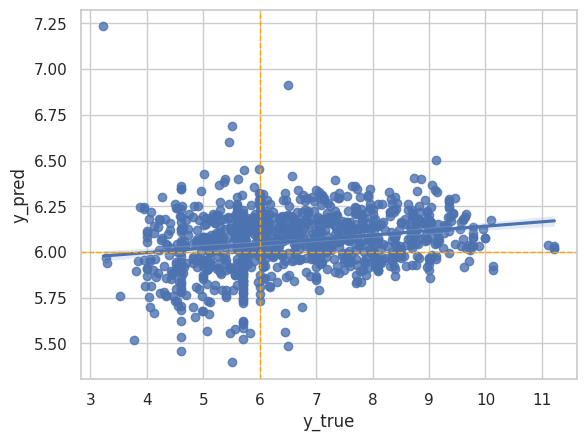

In [37]:
# Compute the performance and generate the plot

res = model_performance(gnn_model, test_loader, test_y, verbose=True, threshold=6)

#### Hyperparameter tuning

 Process of selecting the best set of parameters for a machine learning model and the dataset to improve the performance.

One can perform efficient HP tuning by using frameworks, such as **Optuna** and **Weights & Biases sweep**.

# Virtual screening

Goal - use these models to predict binding affinity with an unknown screening dataset to discover novel potential EGFR inhibitors.

 virtual screening performed on a library of 24,000 compounds specifically designed for discovering novel kinase ATP pocket binders.

In [38]:
import pickle
import numpy as np
import datamol as dm

In [41]:
# load commercial screening library
lib_path = "Enamine_Hinge_Binders_Library_plated_24000cmds_20210316.sdf"
lib_df = dm.read_sdf(lib_path, as_df=True, mol_column="mol")

#### Library statistics

In [42]:
lib_df.head(5)

,smiles,mol,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds
0,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7897832e0f90>,Z57603637,1252574-R-230,A02,219.091,3.141,1,38.91,0
1,c1ccc(Nc2nccs2)nc1,<rdkit.Chem.rdchem.Mol object at 0x7897832e1000>,Z57595474,1252574-R-135,E06,177.226,1.806,1,37.81,2
2,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7897832e1070>,Z56786333,1252574-R-162,E11,204.172,2.125,1,38.91,0
3,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x7897832e10e0>,Z48853893,1252574-R-230,C05,190.265,3.511,1,24.92,2
4,NC(=O)CSc1nc(N)nc(N)n1,<rdkit.Chem.rdchem.Mol object at 0x7897832e1150>,Z17559442,1252574-R-156,B08,200.222,-1.545,3,133.80,3


In [43]:
lib_df.describe(include="all")

,smiles,mol,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds
count,24000,24000,24000,24000,24000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
unique,24000,24000,24000,300,80,NaN,NaN,NaN,NaN,NaN
top,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7897832e0f90>,Z57603637,1252574-R-230,A02,NaN,NaN,NaN,NaN,NaN
freq,1,1,1,80,300,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,348.377242,2.339357,1.406417,75.599830,4.600583
std,NaN,NaN,NaN,NaN,NaN,53.655375,1.339740,0.738477,19.544894,1.584347
min,NaN,NaN,NaN,NaN,NaN,177.226000,-2.841000,0.000000,19.370000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,312.409000,1.418000,1.000000,61.880000,3.000000
50%,NaN,NaN,NaN,NaN,NaN,341.336000,2.370000,1.000000,74.610000,5.000000
75%,NaN,NaN,NaN,NaN,NaN,382.502250,3.250000,2.000000,87.910000,6.000000


### Load the pre-trained models and transformers

In [45]:
# load the fingerprint transformer and random forest model for EGFR binding affinity
with open("rf_regressor.pkl", "rb") as f:
    fp_transformer, rf_model = pickle.load(f)

### Scoring the compounds library with the predictive models

defining a scoring function that converts the molecular SMILES to feature inputs for the predictive models and predicts the pIC50 values.

In [46]:
import torch
from gnn import GCNModel


def score(mol, transformer, model, is_reg=True):
    try:
        # compute the molecular features
        feat = transformer(mol)
        if isinstance(model, GCNModel):
            feat = transformer.get_collate_fn()(transformer(mol))[0]
        # score the molecule
        if is_reg:
            score = model.predict(feat)
        else:
            score = model.predict_proba(feat)[:, 1]
        if torch.is_tensor(score):
            score = score.flatten().numpy()
    except Exception as e:
        score = None
    return score

### Make predictions on pIC50

In [47]:
# Parallelize the scoring
lib_df["rf_preds_pIC50"] = dm.utils.parallelized_with_batches(
    fn=lambda mol: score(mol, fp_transformer, rf_model),
    inputs_list=lib_df.smiles.values,
    batch_size=1000,
    progress=True,
)

  0%|          | 0/24 [00:00<?, ?it/s]

/usr/local/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [48]:
lib_df.head(5)

,smiles,mol,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds,rf_preds_pIC50
0,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7897832e0f90>,Z57603637,1252574-R-230,A02,219.091,3.141,1,38.91,0,5.005350
1,c1ccc(Nc2nccs2)nc1,<rdkit.Chem.rdchem.Mol object at 0x7897832e1000>,Z57595474,1252574-R-135,E06,177.226,1.806,1,37.81,2,5.184000
2,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7897832e1070>,Z56786333,1252574-R-162,E11,204.172,2.125,1,38.91,0,5.543500
3,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x7897832e10e0>,Z48853893,1252574-R-230,C05,190.265,3.511,1,24.92,2,5.206700
4,NC(=O)CSc1nc(N)nc(N)n1,<rdkit.Chem.rdchem.Mol object at 0x7897832e1150>,Z17559442,1252574-R-156,B08,200.222,-1.545,3,133.80,3,4.791527


## Compound prioritization

Number of compounds having predicted pIC50 greater than 6:  1950
Number of compounds having predicted pIC50 greater than 7:  49


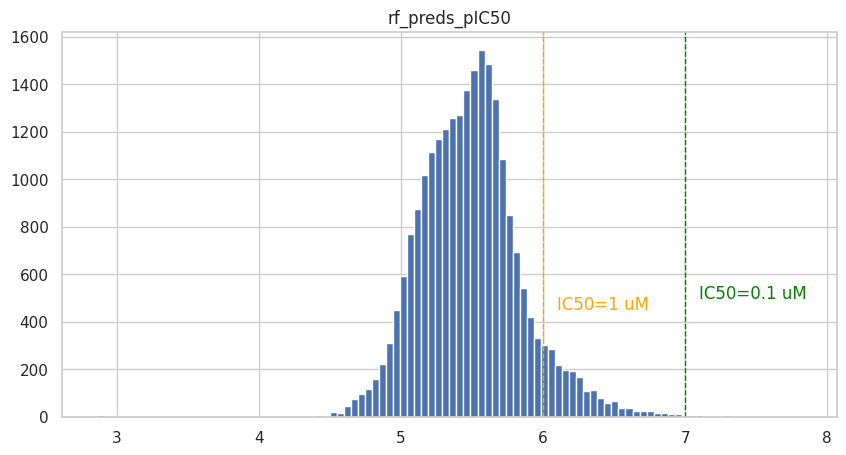

In [49]:
fig = lib_df[["rf_preds_pIC50"]].hist(bins=100, figsize=(10, 5))[0][0]
fig.axvline(6, color="orange", linestyle="dashed", linewidth=1)
fig.annotate("IC50=0.1 uM ", xy=(7, 500), xytext=(7.1, 500), color="green")
fig.axvline(7, color="green", linestyle="dashed", linewidth=1)
fig.annotate("IC50=1 uM", xy=(6, 450), xytext=(6.1, 450), color="orange")

print(
    "Number of compounds having predicted pIC50 greater than 6: ",
    lib_df["rf_preds_pIC50"].gt(6).sum(),
)
print(
    "Number of compounds having predicted pIC50 greater than 7: ",
    lib_df["rf_preds_pIC50"].gt(7).sum(),
)

### Filter molecules by predicted pIC50 values

In [50]:
lib_df_selected = lib_df.query("rf_preds_pIC50 > 6.5")
len(lib_df_selected)

289

#### Filter molecules by the desired molecular weight 280 ~ 400 Dalton

In [51]:
lib_df_selected = lib_df_selected[lib_df_selected["MW (desalted)"].between(280, 400)]
len(lib_df_selected)

228

### Exclude the possible repeated molecules between training set and prioritized set

To make sure that non of the prioritiezed compounds are already in the training set we compare the `unique_id` of molecules, and exlude the repeated molecules from the prioritized set.

In [53]:
import pandas as pd

# Compute the unique id
data_train = pd.read_csv("egfr_pIC50.csv")
data_train["uid"] = data_train["MOL_smiles"].apply(
    lambda smi: dm.unique_id(dm.to_mol(smi))
)
lib_df_selected.loc[:, "uid"] = lib_df_selected["mol"].apply(dm.unique_id).values


# Exclude the molecules in training set from the prioritized set
lib_df_selected = lib_df_selected.query("uid not in @data_train.uid")

len(lib_df_selected )

227

Number of compounds having predicted pIC50 greater than 6.5:  227
Number of compounds having predicted pIC50 greater than 7:  40


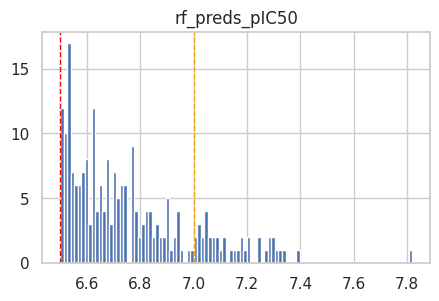

In [54]:
fig = lib_df_selected[["rf_preds_pIC50"]].hist(bins=100, figsize=(5,3))[0][0]
fig.axvline(6.5, color="red", linestyle="dashed", linewidth=1)
fig.axvline(7, color="orange", linestyle="dashed", linewidth=1)
print(
    "Number of compounds having predicted pIC50 greater than 6.5: ",
    lib_df_selected["rf_preds_pIC50"].gt(6).sum(),
)
print(
    "Number of compounds having predicted pIC50 greater than 7: ",
    lib_df_selected["rf_preds_pIC50"].gt(7).sum(),
)

### Distribution in chemical space
The distribution of training set and prioritized molecules in chemical space.

/usr/local/lib/python3.10/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


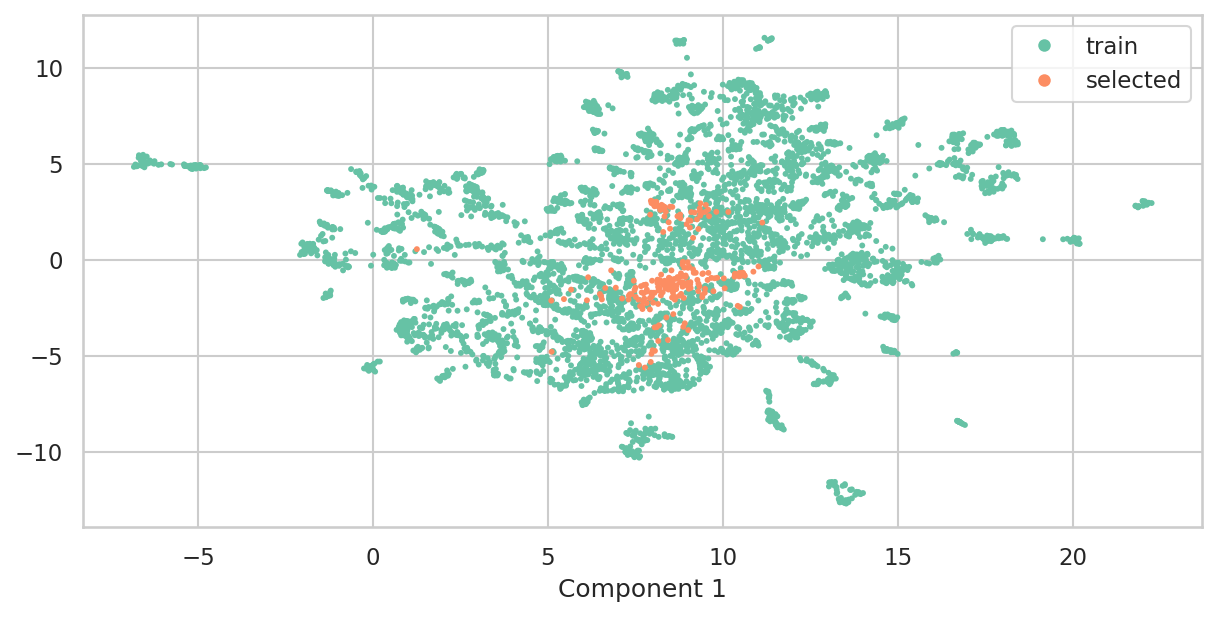

In [55]:
from chemspace_viz import visualize_chemspace

# compute the molecule features
train_feat = fp_transformer(data_train["MOL_smiles"])
lib_feat = fp_transformer(lib_df_selected["mol"])

fig = visualize_chemspace(
    X=np.concatenate([train_feat, lib_feat]),
    y=np.array(["train"] * len(train_feat) + ["selected"] * len(lib_feat)),
    metric="jaccard",
    min_dist=0.5,
    random_state=42,
)

The prioritized molecules (highlighted in orange) are mainly distributed in one cluster in the middle.
Now we use the predicted `pIC50` value to rank order the screened compounds and select a diverse set of these molecules for furture steps.

#### Diverse pick of selected molecules


In [56]:
# Rank the molecules by pIC50
lib_df_selected = lib_df_selected.sort_values(
    by="rf_preds_pIC50", ascending=False
).reset_index(drop=True)

In [57]:
# Select 100 most diverse molecules from the set
picked_index, _ = dm.pick_diverse(
    mols=lib_df_selected.mol.values, npick=100, initial_picks=range(5)
)
lib_df_selected = lib_df_selected.iloc[picked_index]

/usr/local/lib/python3.10/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


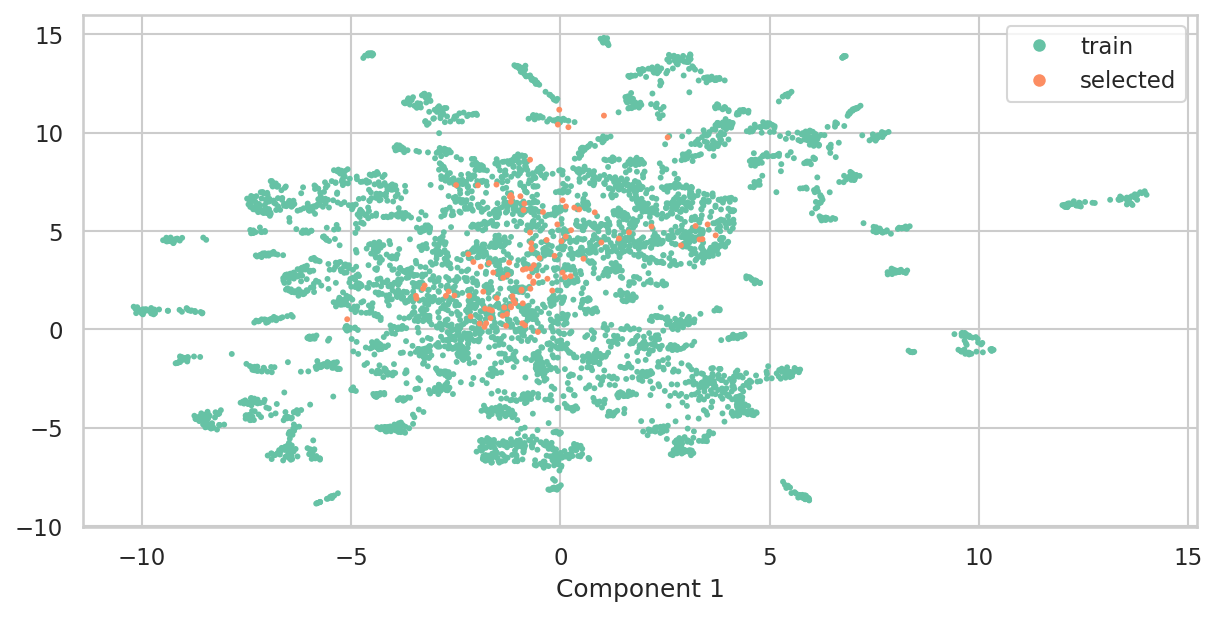

In [58]:
picked_feat = fp_transformer(lib_df_selected["mol"])
fig = visualize_chemspace(
    X=np.concatenate([train_feat, picked_feat]),
    y=np.array(["train"] * len(train_feat) + ["selected"] * len(picked_feat)),
    metric="jaccard",
    min_dist=0.5,
    random_state=42,
)

In [59]:
lib_df_selected

,smiles,mol,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds,rf_preds_pIC50,uid
0,Fc1ccc(-c2cc3ncnc(Nc4ccc5c(c4)OCCO5)c3s2)cc1,<rdkit.Chem.rdchem.Mol object at 0x789781f2fb50>,Z31192075,1252574-R-229,D07,379.407,5.966,1,56.27,3,7.819125,0e6f90b5204e2599204bee49ea621186
1,COCCOc1ccc(Nc2ncnc3c(F)cccc23)cc1Cl,<rdkit.Chem.rdchem.Mol object at 0x789781d0f3e0>,Z1874024228,1252574-R-250,D08,347.771,4.397,1,56.27,6,7.392575,78d9f587281828fa66afb12f25dc55b4
2,C=CCOc1ccccc1C(=O)NC1CCN(C2CCOCC2)CC1,<rdkit.Chem.rdchem.Mol object at 0x789781d67f40>,Z2732658936,1252574-R-275,G03,344.448,1.196,1,50.80,6,7.337177,08c0dd0be6e66591f0f28609e59d29e5
3,C=CCCC(=O)Nc1ccccc1-n1ncc2c(=O)[nH]cnc21,<rdkit.Chem.rdchem.Mol object at 0x789781a98c80>,Z1022039060,1252574-R-232,D04,309.323,1.166,2,88.38,5,7.323427,2886a983b8fa142a03974b335b69dab6
4,C=CCOc1ccccc1C(=O)NC(C)C1CN(C)CCN1C,<rdkit.Chem.rdchem.Mol object at 0x789781d67d10>,Z2732636687,1252574-R-279,G04,317.426,1.401,1,44.81,6,7.309527,aef4075f76b262e08032f5a346108b10
...,...,...,...,...,...,...,...,...,...,...,...,...
196,COCCCn1ccc(Nc2ncnc3sccc23)n1,<rdkit.Chem.rdchem.Mol object at 0x78978213ef80>,Z1272454869,1252574-R-042,B07,289.356,2.166,1,64.86,6,6.536900,1548cb3407a22af988a1b92da3b98b70
31,Cc1cccc(C(=O)Nc2cc(C(C)C)n[nH]2)c1[N+](=O)[O-],<rdkit.Chem.rdchem.Mol object at 0x789780ea3ca0>,Z1097484290,1252574-R-069,G03,288.302,2.141,2,100.92,4,7.049667,4c359a7b090de02bf7b9a983e978d3d4
133,COc1cc2ncnc(NCCOc3ccccc3F)c2cc1OC,<rdkit.Chem.rdchem.Mol object at 0x789781f157e0>,Z118332870,1252574-R-093,D10,343.352,4.190,1,65.50,7,6.646733,727d92b82c0042b8c216cf303fc6bd86
151,O=C(Cn1cc(Nc2ncnc3c(F)cccc23)cn1)N1CCOCC1,<rdkit.Chem.rdchem.Mol object at 0x789781d0f680>,Z1874157935,1252574-R-144,A08,356.354,1.847,1,85.17,4,6.617750,79af302107bef8a0affdafefd7d99ff7


Now we visualize the picked molecules.

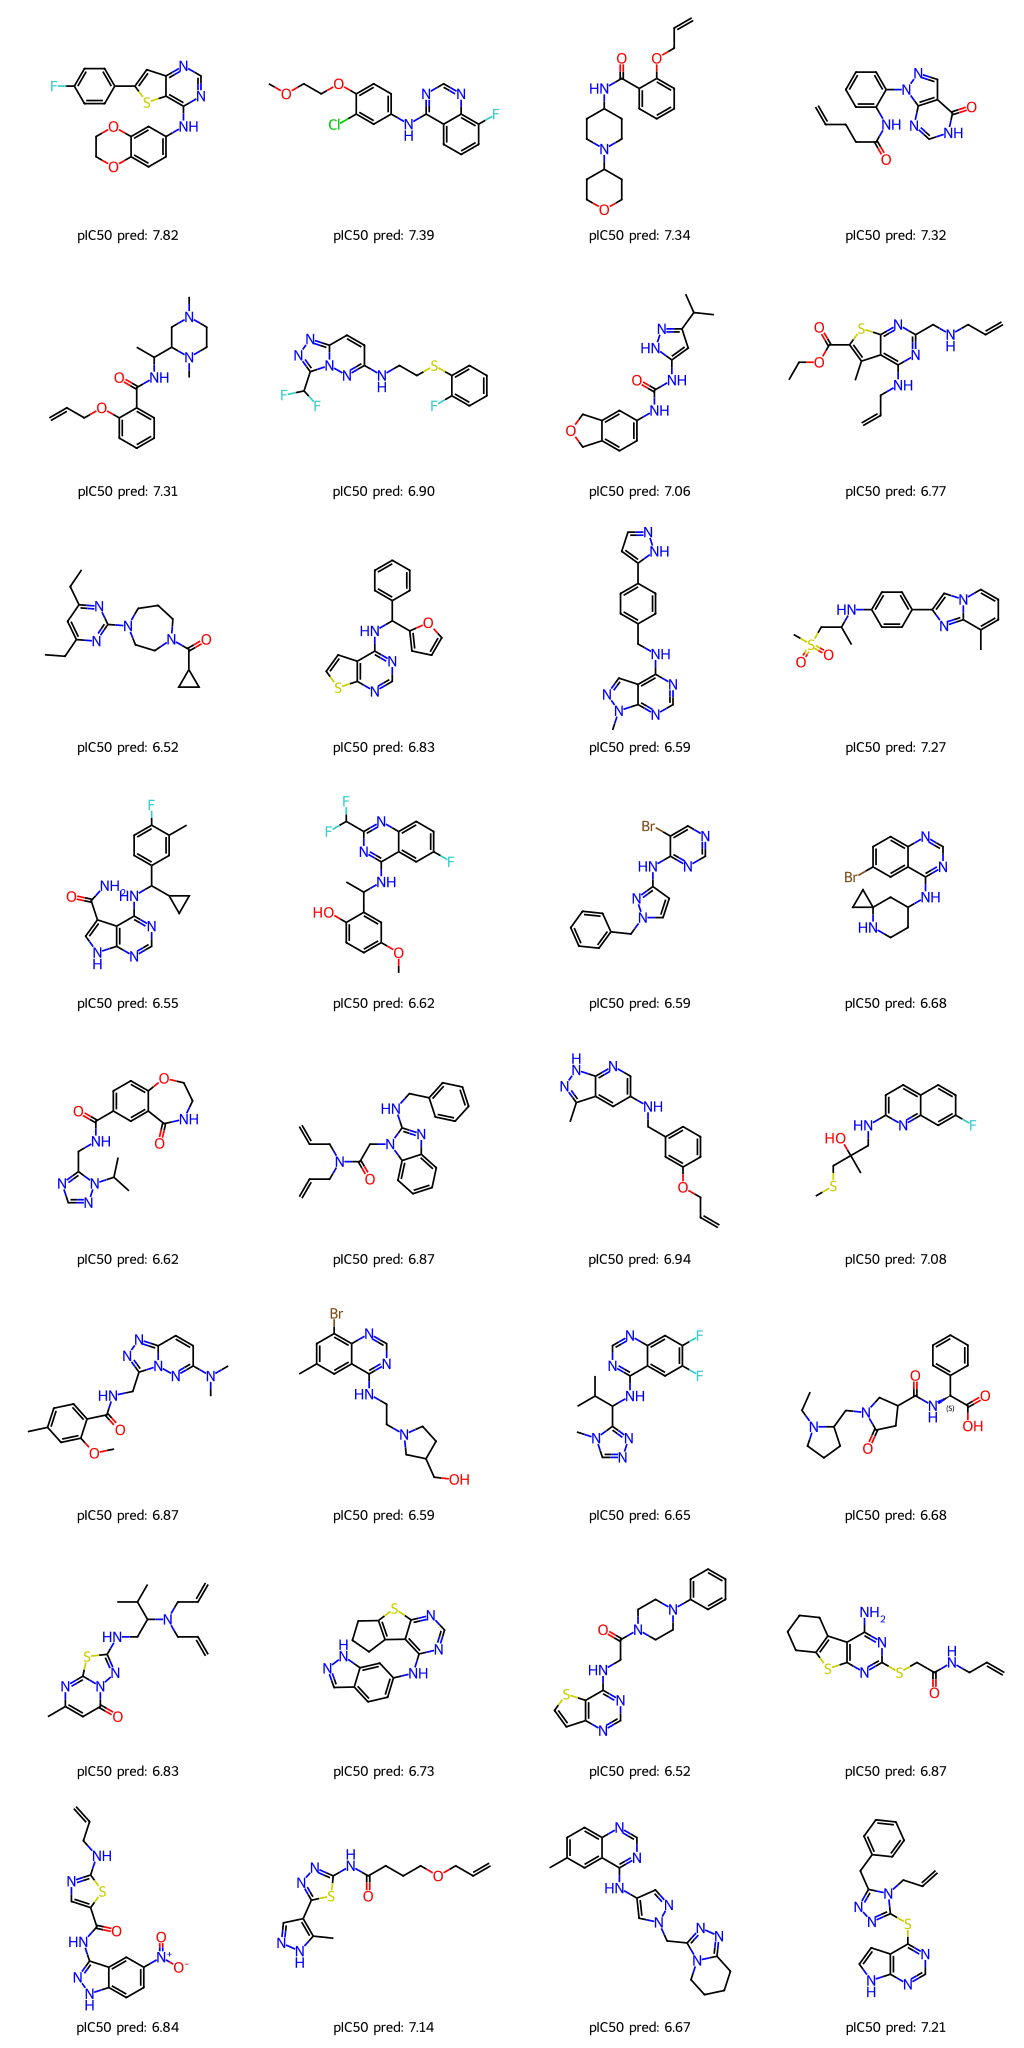

In [60]:
legends = (
    lib_df_selected["rf_preds_pIC50"]
    .apply(lambda x: "pIC50 pred: {:,.2f}".format(x))
    .tolist()
)
dm.to_image(lib_df_selected.mol.tolist(), legends=legends)


These models could be used to rank the compounds and then further study those with the highest predicted binding affinity.


In [61]:
# Export the selected molecules
import os

os.makedirs("output", exist_ok=True)
lib_df_selected.drop(columns="mol").to_csv("output/picked100mols.csv", index=False)